In [1]:
import torch
import torch.nn.functional as F
from torch import nn
import numpy as np
from torch.autograd import Variable
import torchvision.datasets as datasets
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch import optim
from tqdm import tqdm

In [2]:
BATCH_SIZE = 100
NUM_CLASSES = 10
NUM_EPOCHS = 500
NUM_ROUTING_ITERATIONS = 3

In [3]:
def softmax(input, dim=1):
    transposed_input = input.transpose(dim, len(input.size()) - 1)
    softmaxed_output = F.softmax(transposed_input.contiguous().view(-1, transposed_input.size(-1)), dim=-1)
    return softmaxed_output.view(*transposed_input.size()).transpose(dim, len(input.size()) - 1)

In [4]:
def augmentation(x, max_shift=2):
    _, _, height, width = x.size()

    h_shift, w_shift = np.random.randint(-max_shift, max_shift + 1, size=2)
    source_height_slice = slice(max(0, h_shift), h_shift + height)
    source_width_slice = slice(max(0, w_shift), w_shift + width)
    target_height_slice = slice(max(0, -h_shift), -h_shift + height)
    target_width_slice = slice(max(0, -w_shift), -w_shift + width)

    shifted_image = torch.zeros(*x.size())
    shifted_image[ :, :, source_height_slice, source_width_slice] = x[:, :, target_height_slice, target_width_slice]
    return shifted_image.float()

In [5]:
class CapsuleLayer(nn.Module):
    def __init__(self, num_capsules, num_route_nodes, in_channels, out_channels, kernel_size=None, stride=None,
                 num_iterations=NUM_ROUTING_ITERATIONS):
        super(CapsuleLayer, self).__init__()

        self.num_route_nodes = num_route_nodes
        self.num_iterations = num_iterations

        self.num_capsules = num_capsules

        if num_route_nodes != -1:
            self.route_weights = nn.Parameter(torch.randn(num_capsules, num_route_nodes, in_channels, out_channels))
        else:
            self.capsules = nn.ModuleList(
                [nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=0) for _ in
                 range(num_capsules)])

    def squash(self, tensor, dim=-1):
        squared_norm = (tensor ** 2).sum(dim=dim, keepdim=True)
        scale = squared_norm / (1 + squared_norm)
        return scale * tensor / torch.sqrt(squared_norm)

    def forward(self, x):
        if self.num_route_nodes != -1:
            priors = x[None, :, :, None, :] @ self.route_weights[:, None, :, :, :]

            logits = Variable(torch.zeros(*priors.size())).cuda()
            for i in range(self.num_iterations):
                probs = softmax(logits, dim=2)
                outputs = self.squash((probs * priors).sum(dim=2, keepdim=True))

                if i != self.num_iterations - 1:
                    delta_logits = (priors * outputs).sum(dim=-1, keepdim=True)
                    logits = logits + delta_logits
        else:
            outputs = [capsule(x).view(x.size(0), -1, 1) for capsule in self.capsules]
            outputs = torch.cat(outputs, dim=-1)
            outputs = self.squash(outputs)

        return outputs

In [6]:
class CapsuleNet(nn.Module):
    def __init__(self):
        super(CapsuleNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=256, kernel_size=9, stride=1)
        self.primary_capsules = CapsuleLayer(num_capsules=8, num_route_nodes=-1, in_channels=256, out_channels=32,
                                             kernel_size=9, stride=2)
        self.digit_capsules = CapsuleLayer(num_capsules=NUM_CLASSES, num_route_nodes=2048, in_channels=8,
                                           out_channels=16)

        self.decoder = nn.Sequential(
            nn.Linear(16 * NUM_CLASSES, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 3072),
            nn.Sigmoid()
        )

    def forward(self, x, y=None):
        x = F.relu(self.conv1(x), inplace=True)
        x = self.primary_capsules(x)
        x = self.digit_capsules(x).squeeze().transpose(0, 1)

        classes = (x ** 2).sum(dim=-1) ** 0.5
        classes = 100*classes
        #classes = F.softmax(classes, dim=-1)

        if y is None:
            # In all batches, get the most active capsule.
            _, max_length_indices = classes.max(dim=1)
            y = Variable(torch.eye(NUM_CLASSES)).cuda().index_select(dim=0, index=max_length_indices.data)

        reconstructions = self.decoder((x * y[:, :, None]).reshape(x.size(0), -1))

        return classes, reconstructions

In [7]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CapsuleNet().to(device=device)

In [8]:
x = torch.randn(5, 3, 32, 32)
x = x.to(device=device)
y = model(x)
print(y[0].shape)
print(y[0])

torch.Size([5, 10])
tensor([[0.0475, 0.0688, 0.0722, 0.1270, 0.0966, 0.0542, 0.0926, 0.0975, 0.0415,
         0.1447],
        [0.0540, 0.0720, 0.0693, 0.0474, 0.1411, 0.1165, 0.0340, 0.0654, 0.0810,
         0.0717],
        [0.0247, 0.1071, 0.0776, 0.0993, 0.2136, 0.0756, 0.0770, 0.0852, 0.0747,
         0.1502],
        [0.1266, 0.1228, 0.0754, 0.0257, 0.1303, 0.1359, 0.1183, 0.0437, 0.0592,
         0.0874],
        [0.0300, 0.0753, 0.0878, 0.0588, 0.1314, 0.0899, 0.1136, 0.0555, 0.0648,
         0.0571]], device='cuda:0', grad_fn=<MulBackward0>)


In [9]:
# Hyperparameters
in_channels = 3
num_classes = 10
learning_rate = 3e-4 # karpathy's constant
batch_size = 64
num_epochs = 50

In [10]:
train_dataset = datasets.CIFAR10(root='dataset/', train=True, transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = datasets.CIFAR10(root="dataset/", train=False, transform=transforms.ToTensor(), download=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [11]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [12]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [13]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

cat


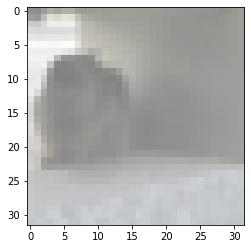

In [14]:
print(classes[labels[63]])
imshow(torchvision.utils.make_grid(images[63]))

In [15]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [16]:
# Train Network
for epoch in range(num_epochs):
    for batch_idx, (data, targets) in enumerate(tqdm(train_loader)):
        # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)

        # forward
        scores = model(data)
        loss = criterion(scores[0], targets)

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()
        
    print('Epoch:', epoch, 'Loss:', loss.item())

  0%|▏                                                                                 | 2/782 [00:00<01:09, 11.23it/s]

Epoch: 0 Loss: 1.6746747493743896


  0%|▏                                                                                 | 2/782 [00:00<01:09, 11.23it/s]

Epoch: 1 Loss: 1.0544264316558838


  0%|▏                                                                                 | 2/782 [00:00<01:10, 11.05it/s]

Epoch: 2 Loss: 1.0425238609313965


  0%|▏                                                                                 | 2/782 [00:00<01:09, 11.23it/s]

Epoch: 3 Loss: 1.221474289894104


  0%|▏                                                                                 | 2/782 [00:00<01:09, 11.23it/s]

Epoch: 4 Loss: 0.4329749345779419


  0%|▏                                                                                 | 2/782 [00:00<01:10, 11.11it/s]

Epoch: 5 Loss: 0.48273181915283203


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 6 Loss: 0.9358599781990051


  0%|▏                                                                                 | 2/782 [00:00<01:09, 11.23it/s]

Epoch: 7 Loss: 0.4293774664402008


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 8 Loss: 0.47218915820121765


  0%|▏                                                                                 | 2/782 [00:00<01:09, 11.17it/s]

Epoch: 9 Loss: 0.25090277194976807


  0%|▏                                                                                 | 2/782 [00:00<01:09, 11.17it/s]

Epoch: 10 Loss: 0.3966723382472992


  0%|▏                                                                                 | 2/782 [00:00<01:09, 11.30it/s]

Epoch: 11 Loss: 0.09170449525117874


  0%|▏                                                                                 | 2/782 [00:00<01:09, 11.17it/s]

Epoch: 12 Loss: 0.22530484199523926


  0%|▏                                                                                 | 2/782 [00:00<01:09, 11.17it/s]

Epoch: 13 Loss: 0.04323694482445717


  0%|▏                                                                                 | 2/782 [00:00<01:08, 11.36it/s]

Epoch: 14 Loss: 0.3869569003582001


  0%|▏                                                                                 | 2/782 [00:00<01:10, 11.11it/s]

Epoch: 15 Loss: 0.14129561185836792


  0%|▏                                                                                 | 2/782 [00:00<01:09, 11.17it/s]

Epoch: 16 Loss: 0.027665408328175545


  0%|▏                                                                                 | 2/782 [00:00<01:09, 11.17it/s]

Epoch: 17 Loss: 0.12200979888439178


  0%|▏                                                                                 | 2/782 [00:00<01:09, 11.23it/s]

Epoch: 18 Loss: 0.03245342895388603


  0%|▏                                                                                 | 2/782 [00:00<01:10, 11.11it/s]

Epoch: 19 Loss: 0.019367242231965065


  0%|▏                                                                                 | 2/782 [00:00<01:09, 11.30it/s]

Epoch: 20 Loss: 0.03914010152220726


  0%|▏                                                                                 | 2/782 [00:00<01:11, 10.93it/s]

Epoch: 21 Loss: 0.1120961382985115


  0%|▏                                                                                 | 2/782 [00:00<01:09, 11.23it/s]

Epoch: 22 Loss: 0.007222407031804323


  0%|▏                                                                                 | 2/782 [00:00<01:10, 11.05it/s]

Epoch: 23 Loss: 0.0033656975720077753


  0%|▏                                                                                 | 2/782 [00:00<01:10, 11.11it/s]

Epoch: 24 Loss: 0.013725641183555126


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 25 Loss: 0.08139373362064362


  0%|                                                                                  | 1/782 [00:00<01:50,  7.04it/s]

Epoch: 26 Loss: 0.0018312478205189109


  0%|                                                                                  | 1/782 [00:00<01:43,  7.52it/s]

Epoch: 27 Loss: 0.0012968595838174224


  0%|                                                                                  | 1/782 [00:00<01:41,  7.69it/s]

Epoch: 28 Loss: 0.0030484383460134268


  0%|                                                                                  | 1/782 [00:00<01:41,  7.69it/s]

Epoch: 29 Loss: 0.0015082224272191525


  0%|                                                                                  | 1/782 [00:00<01:43,  7.52it/s]

Epoch: 30 Loss: 0.8482474088668823


  0%|                                                                                  | 1/782 [00:00<01:48,  7.19it/s]

Epoch: 31 Loss: 0.010047688148915768


  0%|                                                                                  | 1/782 [00:00<01:47,  7.24it/s]

Epoch: 32 Loss: 0.004130391404032707


  0%|                                                                                  | 1/782 [00:00<01:43,  7.57it/s]

Epoch: 33 Loss: 0.0023659563157707453


  0%|                                                                                  | 1/782 [00:00<01:50,  7.09it/s]

Epoch: 34 Loss: 0.0005422939429990947


  0%|                                                                                  | 1/782 [00:00<01:51,  6.99it/s]

Epoch: 35 Loss: 0.15860538184642792


  0%|                                                                                  | 1/782 [00:00<01:43,  7.52it/s]

Epoch: 36 Loss: 0.016460029408335686


  0%|                                                                                  | 1/782 [00:00<01:53,  6.90it/s]

Epoch: 37 Loss: 0.009629190899431705


  0%|                                                                                  | 1/782 [00:00<01:48,  7.19it/s]

Epoch: 38 Loss: 0.0014128293842077255


  0%|                                                                                  | 1/782 [00:00<01:42,  7.63it/s]

Epoch: 39 Loss: 0.0005025639547966421


  0%|                                                                                  | 1/782 [00:00<01:41,  7.69it/s]

Epoch: 40 Loss: 0.24591252207756042


  0%|                                                                                  | 1/782 [00:00<01:45,  7.41it/s]

Epoch: 41 Loss: 0.009612560272216797


  0%|                                                                                  | 1/782 [00:00<01:47,  7.30it/s]

Epoch: 42 Loss: 0.0030606931541115046


  0%|                                                                                  | 1/782 [00:00<01:48,  7.19it/s]

Epoch: 43 Loss: 0.0018779085949063301


  0%|                                                                                  | 1/782 [00:00<01:40,  7.75it/s]

Epoch: 44 Loss: 0.0009772117482498288


  0%|                                                                                  | 1/782 [00:00<01:41,  7.69it/s]

Epoch: 45 Loss: 0.0011669360101222992


  0%|                                                                                  | 1/782 [00:00<01:41,  7.69it/s]

Epoch: 46 Loss: 0.0005720785120502114


  0%|                                                                                  | 1/782 [00:00<01:38,  7.93it/s]

Epoch: 47 Loss: 0.0012494835536926985


  0%|                                                                                  | 1/782 [00:00<01:46,  7.35it/s]

Epoch: 48 Loss: 0.0007858432945795357


100%|████████████████████████████████████████████████████████████████████████████████| 782/782 [03:33<00:00,  3.66it/s]

Epoch: 49 Loss: 0.015577299520373344


In [17]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

index number: 0


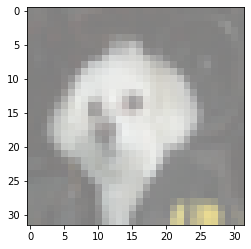

true label: dog
predict label: dog
index number: 1


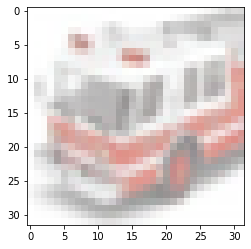

true label: truck
predict label: truck
index number: 2


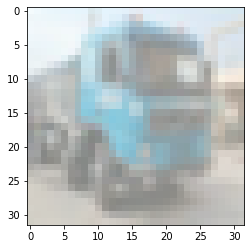

true label: truck
predict label: truck
index number: 3


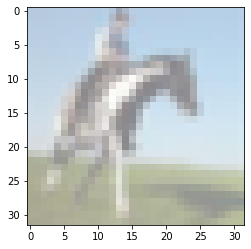

true label: horse
predict label: horse
index number: 4


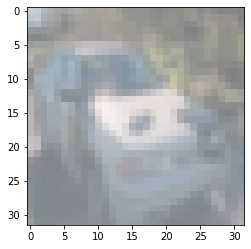

true label: car
predict label: ship
index number: 5


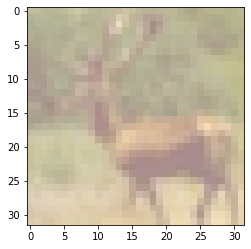

true label: deer
predict label: deer
index number: 6


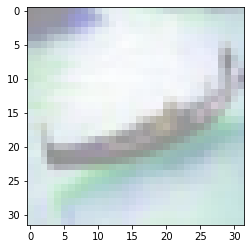

true label: ship
predict label: ship
index number: 7


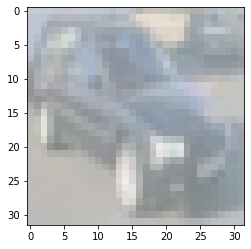

true label: car
predict label: car
index number: 8


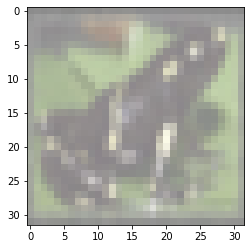

true label: frog
predict label: frog
index number: 9


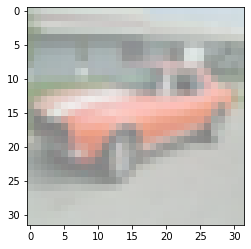

true label: car
predict label: car
index number: 10


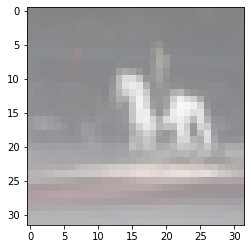

true label: horse
predict label: horse
index number:  


In [18]:
while True:
    i = input("index number: ")
    if i == ' ':
        break
    i = int(i)
    imshow(torchvision.utils.make_grid(images[i]))
    print('true label:',classes[labels[i]])
    prediction = model(images.to(device=device))
    max_index = np.argmax(prediction[0][i,:].cpu().detach().numpy())
    print('predict label:',classes[max_index])